In [3]:
%matplotlib  inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [4]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


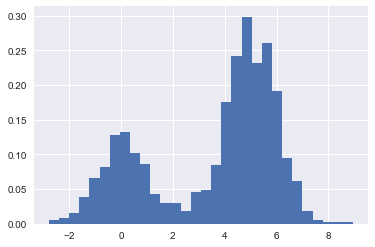

In [5]:
hist = plt.hist(x, bins=30, normed=True)

In [7]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

In [8]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


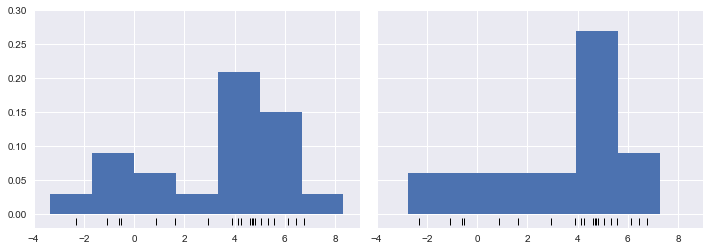

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                      sharex=True, sharey = True,
                      subplot_kw={'xlim':(-4, 9),
                                 'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, normed=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
              markeredgewidth=1)

(-0.2, 8)

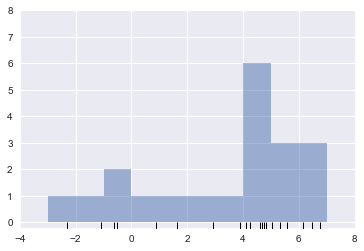

In [10]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
       markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i),1, 1,
                                  alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

[-4, 8, -0.2, 8]

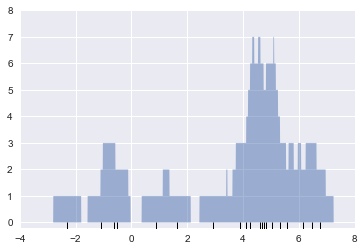

In [11]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8])

[-4, 8, -0.2, 5]

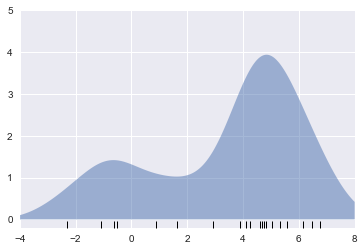

In [12]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5])

(-0.02, 0.22)

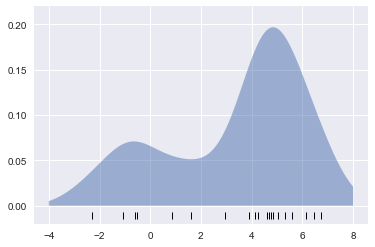

In [13]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

In [17]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                   {'bandwidth': bandwidths},
                   cv=LeaveOneOut(len(x)))
grid.fit(x[:, None]);

In [20]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

In [21]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

latlon = np.vstack([data.train['dd lat'],
                   data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                   for d in data.train['species']], dtype='int')

In [24]:
from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids

xgrid, ygrid = construct_grids(data)

m = Basemap(projection='cyl', resolution='c',
           llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
           llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

m.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
         c=species, cmap='rainbow', latlon=True)

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [25]:
# Set up the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# Create two side-by-side plots
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])
    
    # plot coastlines with basemap
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='c', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    
    # construct a spherical kernel density estimate of the distribution
    kde = KernelDensity(bandwidth=0.03, metric='haversine')
    kde.fit(np.radians(latlon[species == i]))

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

NameError: name 'xgrid' is not defined

In [26]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                     kernel=self.kernel).fit(Xi)
                       for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                          for Xi in training_sets]
        return self
    
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                            for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
    
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [27]:
from sklearn.datasets import load_digits
from sklearn.grid_search import GridSearchCV

digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)

scores = [val.mean_validation_score for val in grid.grid_scores_]

{'bandwidth': 7.0548023107186433}
accuracy = 0.9666110183639399


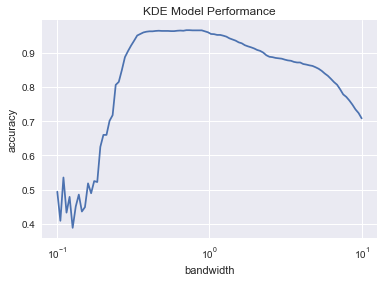

In [28]:
plt.semilogx(bandwidth, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
cross_val_score(GaussianNB())